# Introduction to Reinforcement Learning

References:
- "Deep Reinforcement Learning in Action"
- Thomas Simonini's course
- David Silver's RL course

Reinforcement Learning (RL) is a branch of machine learning. The idea behind RL is that
an **agent** (an AI) will learn from the **environment** by interacting with it (through
trial and error) and receiving **rewards** (negative or positive) as feedback for
performing actions. RL is a framework for solving control tasks (also called **decision
problems**). 

Examples:
- Fly stunt manoeuvres in a helicopter
- Defeat the world champion at Backgammon
- Manage an investment portfolio
- Control a power station
- Make a humanoid robot walk
- Play many diﬀerent Atari games better than humans

RL algorithm can, in principle, employ any statistical learning model, but it has become
increasingly popular and effective to use deep neural networks.

- state, action, environment, reward, RL loop

In [13]:
import random
import matplotlib.pyplot as plt
import numpy as np

## Solving the multi-arm bandit

Consider $n$ slot machines, each having 1 lever. We call this situation an $n$-armed
bandit. We have $n$ possible actions (here $n = 10$) where an action means pulling the
arm, or lever, of a particular slot machine, and at each play ($k$) of this game we can
choose a single lever to pull. After taking an action ($a$) we will receive a reward,
$R_k$ (reward at play $k$). Each lever has a unique probability distribution of 
payouts (rewards).

We implement our reward probability distributions for each arm in the following way: 
Each arm will have a probability, e.g., 0.7, and the maximum reward is $10.
We will set up a for loop going to 10, and at each step it will add 1 to the reward if a
random float is less than the arm’s probability.

In [6]:

def get_reward(prob, n=10):
    reward = 0;
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

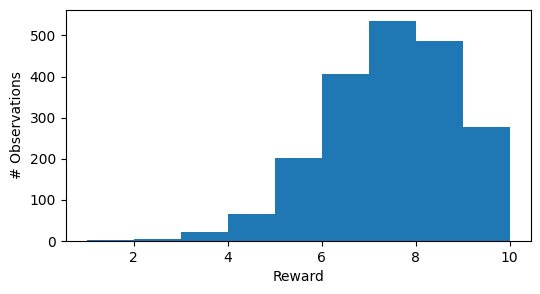

In [21]:
# reward distribution for a 10-armed bandit with probability 0.7
reward_test = [get_reward(0.7) for _ in range(2000)]

plt.figure(figsize=(6,3))
plt.xlabel("Reward")
plt.ylabel("# Observations")
plt.hist(reward_test,bins=9)
plt.show()

Our strategy should be to play a few times, choosing different levers and observing
our rewards for each action. Then we want to only choose the lever with the largest
observed average reward.

- **Action-value function** $Q_k(a)$: gives the value of the action $a$ at play $k$ as the
arithmetic mean of all previous rewards received for taking action $a$ (**expected
reward**).

This method of simply choosing the best lever that we know of so far
is called a **greedy** (or exploitation) method. We need some **exploration** 
of other levers (other slot machines) to discover the true best action.

We can use an **(epsilon)-greedy** strategy, such that with a probability, epsilon, 
we will choose an action, a, and the rest of the time we will choose the best lever
(maximizes action-value function).

In [10]:
def update_record(record,action,r):
    # compute new average reward
    new_r = (record[action,0] * record[action,1] + r) / (record[action,0] + 1)
    record[action,0] += 1
    record[action,1] = new_r
    return record

In [11]:
def get_best_arm(record):
    arm_index = np.argmax(record[:,1],axis=0)
    return arm_index

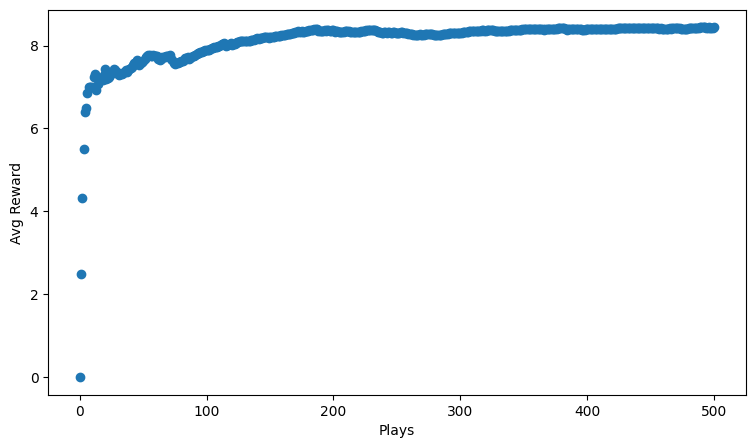

In [14]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)

n = 10
eps = 0.2 # epsilon parameter
probs = np.random.rand(n) # bandit probabilities

# for each arm store the number of times pulled and the average reward
record = np.zeros((n,2)) 

rewards = [0]
# play games
for i in range(500):
    # epsilon-greedy strategy
    if random.random() > eps:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(n)

    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)
plt.show()

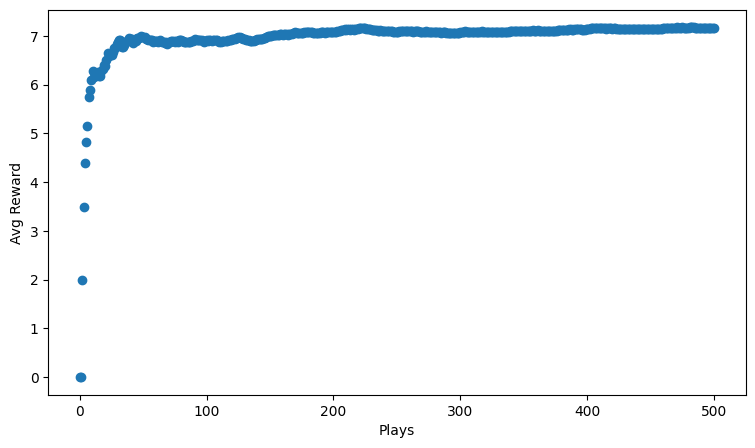

In [19]:
def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm
probs = np.random.rand(n)
record = np.zeros((n,2))
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    p = softmax(record[:,1],tau=0.7)
    choice = np.random.choice(np.arange(n),p=p)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

## Introducing state: contextual bandits

In [20]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward